# Stock Market Prediction and Forecasting

## Importing Libraries

In [100]:
#pip install pandas-datareader

In [101]:
#pip install tensorflow

In [102]:
# conda install tensorflow

In [103]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [104]:
key='bc1d976a3563e0e50951ec7c3631ef451dbcdb61'

In [105]:
df=pdr.get_data_tiingo('BLK',api_key=key)

/Users/prathameshrege/opt/anaconda3/lib/python3.9/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [106]:
df.to_csv('BLK.csv')

In [107]:
df=pd.read_csv('BLK.csv')

In [108]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,BLK,2019-08-06 00:00:00+00:00,435.71,437.89,430.22,435.39,418125,382.902703,384.818491,378.078081,382.621486,418125,0.0,1.0
1,BLK,2019-08-07 00:00:00+00:00,430.39,432.79,423.46,426.74,573953,378.227478,380.336602,372.137382,375.019851,573953,0.0,1.0
2,BLK,2019-08-08 00:00:00+00:00,437.62,438.44,431.60,434.00,499922,384.581214,385.301831,379.290828,381.399952,499922,0.0,1.0
3,BLK,2019-08-09 00:00:00+00:00,426.33,435.11,425.85,435.02,649988,374.659543,382.375422,374.237718,382.296330,649988,0.0,1.0
4,BLK,2019-08-12 00:00:00+00:00,416.44,425.94,414.46,420.24,642600,365.968193,374.316810,364.228166,369.307640,642600,0.0,1.0


The starting year for our stock data is 2019

In [109]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,BLK,2024-07-29 00:00:00+00:00,862.15,865.1700,852.3700,858.00,612694,862.15,865.1700,852.3700,858.00,612694,0.0,1.0
1253,BLK,2024-07-30 00:00:00+00:00,872.59,873.8929,865.1772,868.13,539579,872.59,873.8929,865.1772,868.13,539579,0.0,1.0
1254,BLK,2024-07-31 00:00:00+00:00,876.50,885.1000,871.9000,875.32,656942,876.50,885.1000,871.9000,875.32,656942,0.0,1.0
1255,BLK,2024-08-01 00:00:00+00:00,865.35,884.6700,860.3200,880.00,586568,865.35,884.6700,860.3200,880.00,586568,0.0,1.0
1256,BLK,2024-08-02 00:00:00+00:00,846.02,858.2000,839.2900,855.00,479910,846.02,858.2000,839.2900,855.00,479910,0.0,1.0


As we can see the csv file conatins the stock data till the latest date. We have 5 years of stock data in our dataset. The dataset gets updated each day

We will select the 'Close' column as our target column and make predictions on this column

In [110]:
df1=df.reset_index()['close']

In [111]:
df1.shape

(1257,)

In [112]:
df1

0       435.71
1       430.39
2       437.62
3       426.33
4       416.44
         ...  
1252    862.15
1253    872.59
1254    876.50
1255    865.35
1256    846.02
Name: close, Length: 1257, dtype: float64

Lets plot the target column

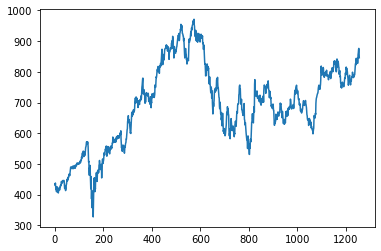

In [113]:
plt.plot(df1)

Applying MinMax scaling as LSTM models are sensitive to scale of data

In [114]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [115]:
df1

array([[0.1681339 ],
       [0.15987393],
       [0.17109941],
       ...,
       [0.85251603],
       [0.83520425],
       [0.80519198]])

## Train Test Split

In [116]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size

In [117]:
training_size,test_size

(817, 440)

In [118]:
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [119]:
len(test_data)

440

We will create a function to convert the array of values into a dataset matrix

In [120]:
def create_dataset(dataset,time_step=1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [121]:
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [122]:
print(X_train.shape),print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [123]:
print(X_test.shape),print(y_test.shape)

(339, 100)
(339,)


(None, None)

We will now reshape the input into 3 dimensions [samples,time steps,features] which is required for LSTM

In [124]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## Model Training

We will now create the Stacked LSTM Model

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [126]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [127]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 351ms/step - loss: 0.1168 - val_loss: 0.0060
Epoch 2/100
12/12 [==============================] - 2s 167ms/step - loss: 0.0155 - val_loss: 0.0071
Epoch 3/100
12/12 [==============================] - 2s 185ms/step - loss: 0.0091 - val_loss: 0.0044
Epoch 4/100
12/12 [==============================] - 2s 159ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 5/100
12/12 [==============================] - 2s 153ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 6/100
12/12 [==============================] - 2s 152ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 7/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 8/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 9/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 10/100
12/12 [==============================] - 2s 207ms/step - loss: 0.0037 - val_lo

12/12 [==============================] - 3s 222ms/step - loss: 0.0010 - val_loss: 5.4486e-04
Epoch 80/100
12/12 [==============================] - 3s 232ms/step - loss: 0.0012 - val_loss: 5.3977e-04
Epoch 81/100
12/12 [==============================] - 2s 206ms/step - loss: 0.0012 - val_loss: 5.2235e-04
Epoch 82/100
12/12 [==============================] - 2s 171ms/step - loss: 9.8965e-04 - val_loss: 5.4024e-04
Epoch 83/100
12/12 [==============================] - 2s 171ms/step - loss: 9.4447e-04 - val_loss: 7.1257e-04
Epoch 84/100
12/12 [==============================] - 2s 158ms/step - loss: 9.4275e-04 - val_loss: 5.1137e-04
Epoch 85/100
12/12 [==============================] - 2s 160ms/step - loss: 9.5413e-04 - val_loss: 6.3152e-04
Epoch 86/100
12/12 [==============================] - 2s 158ms/step - loss: 0.0010 - val_loss: 4.9874e-04
Epoch 87/100
12/12 [==============================] - 2s 158ms/step - loss: 8.8472e-04 - val_loss: 5.0180e-04
Epoch 88/100
12/12 [===================

Now lets do the predictions and check performance metrics

In [129]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 28ms/step


We will transform back to the original form

In [130]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

We will now calculate the RMSE performance metrics

In [131]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

717.0725364330297

In [132]:
math.sqrt(mean_squared_error(y_test,test_predict))

743.8078221376983

## Predictions Visualization

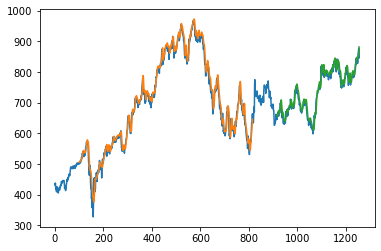

In [133]:
#Shift Train predictions for plotting
look_back=100
trainPredictPlot=np.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

#Shift Test predictions for plotting
testPredictPlot=np.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:]=test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predictions of next 30 days

In [134]:
len(test_data)

440

We will now take the latest 100 days 

In [135]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

We will now convert this data into a list

In [136]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [137]:
temp_input

[0.7796823326657041,
 0.7740928781033118,
 0.7474032325678885,
 0.7376527396090486,
 0.7341282779822069,
 0.7373111618302357,
 0.7615166053379292,
 0.799043582219324,
 0.7722918316332077,
 0.7589081932088129,
 0.7651031720154642,
 0.7882683559240455,
 0.7860636266244354,
 0.77530392659183,
 0.7594981911903986,
 0.7567189901718756,
 0.7214588476407844,
 0.729951713323086,
 0.7388948406229137,
 0.7397953638579657,
 0.708354681944509,
 0.7119412486220442,
 0.6769140000310525,
 0.6762774232614468,
 0.6555964413805953,
 0.6619932616019997,
 0.6519167171270204,
 0.656077755523468,
 0.671805859611533,
 0.681913456611859,
 0.6759824242706538,
 0.6679863989938981,
 0.6761066343720403,
 0.6736224323443103,
 0.6633129939292313,
 0.6585619575511978,
 0.6669771919201328,
 0.6777058394273914,
 0.6943655192758551,
 0.704116012234695,
 0.7000947102023072,
 0.7168630738894841,
 0.7285698759451611,
 0.7187262254102815,
 0.7383358951666745,
 0.758116353812474,
 0.7457108699364976,
 0.7527132144021613,
 0

In [138]:
#Demonstrating predictions for next 30 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1, n_steps, 1))
        y_hat=model.predict(x_input,verbose=0)
        print("{} day input {}".format(i,y_hat))
        temp_input.extend(y_hat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(y_hat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        y_hat=model.predict(x_input,verbose=0)
        print(y_hat[0])
        temp_input.extend(y_hat[0].tolist())
        print(len(temp_input))
        lst_output.extend(y_hat.tolist())
        i=i+1

[0.85376775]
101
1 day input [0.77409288 0.74740323 0.73765274 0.73412828 0.73731116 0.76151661
 0.79904358 0.77229183 0.75890819 0.76510317 0.78826836 0.78606363
 0.77530393 0.75949819 0.75671899 0.72145885 0.72995171 0.73889484
 0.73979536 0.70835468 0.71194125 0.676914   0.67627742 0.65559644
 0.66199326 0.65191672 0.65607776 0.67180586 0.68191346 0.67598242
 0.6679864  0.67610663 0.67362243 0.66331299 0.65856196 0.66697719
 0.67770584 0.69436552 0.70411601 0.70009471 0.71686307 0.72856988
 0.71872623 0.7383359  0.75811635 0.74571087 0.75271321 0.74179825
 0.74139457 0.7331346  0.70975205 0.70563759 0.68935054 0.66632509
 0.67452296 0.69031316 0.69860419 0.71090099 0.71647492 0.70040524
 0.68512739 0.68121477 0.66795535 0.68733212 0.68671107 0.68612107
 0.70436443 0.70835468 0.70708153 0.71448756 0.73210986 0.72502989
 0.71425466 0.70444206 0.71405282 0.70621206 0.71686307 0.71684755
 0.71914543 0.71850886 0.73728011 0.75237164 0.77235394 0.77716708
 0.76938842 0.80196252 0.79753753

12 day input [[0.9052292]]
13 day input [0.77530393 0.75949819 0.75671899 0.72145885 0.72995171 0.73889484
 0.73979536 0.70835468 0.71194125 0.676914   0.67627742 0.65559644
 0.66199326 0.65191672 0.65607776 0.67180586 0.68191346 0.67598242
 0.6679864  0.67610663 0.67362243 0.66331299 0.65856196 0.66697719
 0.67770584 0.69436552 0.70411601 0.70009471 0.71686307 0.72856988
 0.71872623 0.7383359  0.75811635 0.74571087 0.75271321 0.74179825
 0.74139457 0.7331346  0.70975205 0.70563759 0.68935054 0.66632509
 0.67452296 0.69031316 0.69860419 0.71090099 0.71647492 0.70040524
 0.68512739 0.68121477 0.66795535 0.68733212 0.68671107 0.68612107
 0.70436443 0.70835468 0.70708153 0.71448756 0.73210986 0.72502989
 0.71425466 0.70444206 0.71405282 0.70621206 0.71686307 0.71684755
 0.71914543 0.71850886 0.73728011 0.75237164 0.77235394 0.77716708
 0.76938842 0.80196252 0.79753753 0.77876628 0.78140575 0.80087568
 0.80312699 0.77667024 0.79047309 0.82099772 0.83023584 0.84644526
 0.85251603 0.83520425

24 day input [[0.975546]]
25 day input [0.66199326 0.65191672 0.65607776 0.67180586 0.68191346 0.67598242
 0.6679864  0.67610663 0.67362243 0.66331299 0.65856196 0.66697719
 0.67770584 0.69436552 0.70411601 0.70009471 0.71686307 0.72856988
 0.71872623 0.7383359  0.75811635 0.74571087 0.75271321 0.74179825
 0.74139457 0.7331346  0.70975205 0.70563759 0.68935054 0.66632509
 0.67452296 0.69031316 0.69860419 0.71090099 0.71647492 0.70040524
 0.68512739 0.68121477 0.66795535 0.68733212 0.68671107 0.68612107
 0.70436443 0.70835468 0.70708153 0.71448756 0.73210986 0.72502989
 0.71425466 0.70444206 0.71405282 0.70621206 0.71686307 0.71684755
 0.71914543 0.71850886 0.73728011 0.75237164 0.77235394 0.77716708
 0.76938842 0.80196252 0.79753753 0.77876628 0.78140575 0.80087568
 0.80312699 0.77667024 0.79047309 0.82099772 0.83023584 0.84644526
 0.85251603 0.83520425 0.80519198 0.85376775 0.84485304 0.84268433
 0.8457374  0.85169977 0.85888612 0.86636126 0.8736825  0.88066566
 0.88725984 0.89349306 

In [139]:
print(lst_output)

[[0.8537677526473999], [0.8448530435562134], [0.8426843285560608], [0.8457373976707458], [0.8516997694969177], [0.8588861227035522], [0.8663612604141235], [0.8736824989318848], [0.88066565990448], [0.887259840965271], [0.8934930562973022], [0.899446427822113], [0.9052292108535767], [0.9109525680541992], [0.9167085886001587], [0.9225530028343201], [0.92850261926651], [0.9345398545265198], [0.9406226873397827], [0.9466978311538696], [0.9527136087417603], [0.9586276412010193], [0.9644112586975098], [0.9700510501861572], [0.9755460023880005], [0.9809041619300842], [0.9861387610435486], [0.9912639260292053], [0.9962921738624573], [1.0012329816818237]]


In [140]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [141]:
len(df1)

1257

In [142]:
df1[1157:].shape

(100, 1)

In [143]:
len(lst_output)

30

In [144]:
lst_output

[[0.8537677526473999],
 [0.8448530435562134],
 [0.8426843285560608],
 [0.8457373976707458],
 [0.8516997694969177],
 [0.8588861227035522],
 [0.8663612604141235],
 [0.8736824989318848],
 [0.88066565990448],
 [0.887259840965271],
 [0.8934930562973022],
 [0.899446427822113],
 [0.9052292108535767],
 [0.9109525680541992],
 [0.9167085886001587],
 [0.9225530028343201],
 [0.92850261926651],
 [0.9345398545265198],
 [0.9406226873397827],
 [0.9466978311538696],
 [0.9527136087417603],
 [0.9586276412010193],
 [0.9644112586975098],
 [0.9700510501861572],
 [0.9755460023880005],
 [0.9809041619300842],
 [0.9861387610435486],
 [0.9912639260292053],
 [0.9962921738624573],
 [1.0012329816818237]]

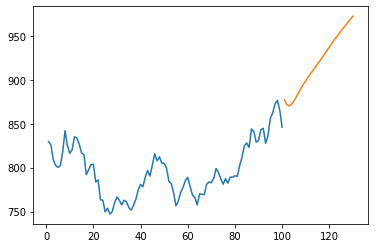

In [145]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

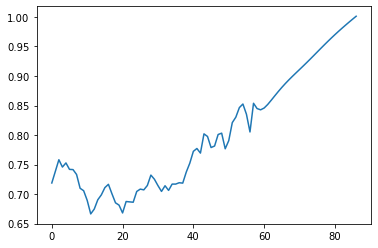

In [147]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [149]:
df3=scaler.inverse_transform(df3).tolist()

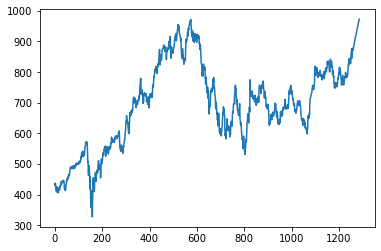

In [150]:
plt.plot(df3)